# Lab 3 - Network Intrusion Detection
- Daniel Vance
- Peter Thung
- Ravi Srinivas
- Randy Balzer

## Business Understanding

Daniel

*Describe the purpose of the data set you selected. How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific data set and the stakeholders' needs?*

## Data Understanding

Daniel

- *Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?*
- *Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.*

In [84]:
# Setup
# Imports
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn import metrics as mt
from sklearn.svm import SVC

from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import RandomizedPCA 
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.pipeline import Pipeline
from sklearn import metrics as mt

import seaborn as sns
import pandas as pd
import numpy as np


%matplotlib inline

In [85]:
# Load UNSW_NB15 into a Pandas dataframe
df = pd.read_csv('UNSW_NB15_training_set.csv', encoding='utf-8-sig')
# Grab out the count of number of unique values in the attack_cat variable prior to removing it
# to use as a potential K value for Kmeans clustering algorithm

attack_cat = df.attack_cat.unique()
attack_cat_count = len(attack_cat)
print("Number of unique attack categories", attack_cat_count)
# Lets remove attributes that are not useful to us during this first analysis pass
non_useful_features_list = ['id', 'attack_cat']
# id: n internal variable to just ref an obseration. deemed not usefl
# attack_cat: first try and just predict the label. 
#             It will obviously 1:1 correlate with label
#             We can circle back and swap it out with label 
#             to see if we get any better accuracy on an 
#             on an attack type level
for feature in non_useful_features_list:
    if feature in df:
        df.drop(feature, axis=1, inplace=True)  # Lets drop id as it is an internal variable to just ref an obseratio
        
# Overwrite the existing dataframe with the new dataframe that does not contain the 
# four unwanted records and confirm we have 4 less records (shold have 82328 observations)
if "is_ftp_login" in df:
    df = df[df.is_ftp_login != 2]
    if len(df) == 82328:
        print "duplicate record deleted successfully: " + str(len(df)) + " observations remaining" 
# Check to see if non useful features still exist in dataframe, if so, we did something wrong
for feature in non_useful_features_list:
    if feature in df:
        print "[" + feature + "]" + "still found, check removal code. (Should not see this)"      

df_five = df[['sttl','ct_dst_sport_ltm', 'ct_src_dport_ltm', 'swin', 'dwin', 'label' ]] 

df_five.info()
df_five.describe()

('Number of unique attack categories', 10)
duplicate record deleted successfully: 82328 observations remaining
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Data columns (total 6 columns):
sttl                82328 non-null int64
ct_dst_sport_ltm    82328 non-null int64
ct_src_dport_ltm    82328 non-null int64
swin                82328 non-null int64
dwin                82328 non-null int64
label               82328 non-null int64
dtypes: int64(6)
memory usage: 4.4 MB


,sttl,ct_dst_sport_ltm,ct_src_dport_ltm,swin,dwin,label
count,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000,82328.000000
mean,180.973448,3.663092,4.929040,133.453175,128.280464,0.550578
std,101.512436,5.915518,8.389724,127.357276,127.491408,0.497438
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,62.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,254.000000,1.000000,1.000000,255.000000,255.000000,1.000000
75%,254.000000,3.000000,4.000000,255.000000,255.000000,1.000000
max,255.000000,38.000000,59.000000,255.000000,255.000000,1.000000


## Data Preparation:¶
Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [91]:
# One-hot encode our object features:

# http://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers
# Surrounding code in try/except on case where there are no object type features to one-hot encode
try:
    tmp_df = df.describe(include=['O'])  # creates a temporary df with just categorical features that are of object type
    categorical_object_col_name_list = tmp_df.columns.values.tolist()
    for col_name in categorical_object_col_name_list:
        #print col_name
        tmp_df = pd.get_dummies(df[col_name], prefix=col_name)
        df = pd.concat((df,tmp_df), axis=1)
        df.drop(col_name, axis=1, inplace=True)  # go ahead and drop original feature as it has now been one-hot encoded
except ValueError as e:
    print "Value error({0}): ".format(e)  # Note
df.info()

Value error(No objects to concatenate): 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(162), int64(29)
memory usage: 120.6 MB


In [92]:
# Go ahead and drop both 'label' 
dfcopy = df.copy(deep=True) # preserve original dataframe that has our dependent variable
dfcopy.info()
#http://pandas.pydata.org/pandas-docs/version/0.18.1/generated/pandas.DataFrame.sample.html
dfCopyHalf = dfcopy.sample(frac=.005)
dfcopy = dfCopyHalf
# we want to predict the X and y data as follows:
if 'label' in dfcopy:
    y = dfcopy['label'].values # get the labels we want
    del dfcopy['label'] # get rid of the class label
    X = dfcopy.values # use everything else to cluster!
dfcopy.info() # should have 190 featurers, ~40k entries
#http://pandas.pydata.org/pandas-docs/version/0.18.1/generated/pandas.DataFrame.sample.html

    # X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    # have converted them into simple matrices to use with scikit learn


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82328 entries, 0 to 82331
Columns: 191 entries, dur to state_RST
dtypes: float64(162), int64(29)
memory usage: 120.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 412 entries, 71893 to 28318
Columns: 190 entries, dur to state_RST
dtypes: float64(162), int64(28)
memory usage: 614.8 KB


In [87]:
pd.set_option('display.max_columns', 500)
dfcopy.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
count,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,4.120000e+02,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,4.120000e+02,4.120000e+02,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000
mean,0.802402,17.798544,40.186893,4061.817961,43975.111650,95889.921817,180.293689,91.041262,8.269606e+07,689131.999606,3.201456,17.939320,388.406615,96.163556,6188.389576,462.261406,133.689320,1.097451e+09,9.519038e+08,125.643204,0.056769,0.027610,0.029159,159.179612,109.565534,0.084951,1343.293689,9.881068,1.381068,5.854369,4.813107,3.490291,7.611650,0.012136,0.012136,0.126214,6.359223,9.550971,0.007282
std,3.955333,83.727403,537.250046,17026.318119,721052.362075,178648.222057,102.195241,114.941647,2.251225e+08,2412412.100645,7.535525,268.617491,4218.624716,875.950877,60571.784329,2437.142307,127.504518,1.402489e+09,1.278484e+09,127.641478,0.145878,0.071078,0.084931,233.105287,232.349898,0.279148,19574.748404,11.039541,1.151718,7.960557,7.908019,5.594784,11.341617,0.109626,0.109626,0.611004,7.919122,11.108613,0.085124
min,0.000000,1.000000,0.000000,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,39.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.000008,2.000000,0.000000,114.000000,0.000000,28.864416,62.000000,0.000000,1.258315e+04,0.000000,0.000000,0.000000,0.008000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000
50%,0.005863,6.000000,2.000000,564.000000,178.000000,2798.509862,254.000000,29.000000,6.278774e+05,1838.408874,1.000000,0.000000,0.479206,0.009000,16.318723,0.000000,255.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,65.000000,44.000000,0.000000,0.000000,6.000000,1.000000,3.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000
75%,0.663749,12.000000,10.000000,1540.000000,830.000000,125000.000300,254.000000,252.000000,8.888889e+07,23318.995120,3.000000,2.000000,55.984806,55.786144,3026.191321,110.168092,255.000000,2.191444e+09,1.822121e+09,255.000000,0.103908,0.046738,0.046070,113.000000,81.000000,0.000000,0.000000,12.000000,2.000000,6.000000,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,12.000000,0.000000
max,59.983105,1642.000000,10872.000000,185550.000000,14590859.000000,1000000.003000,255.000000,252.000000,2.128000e+09,15132475.000000,76.000000,5436.000000,60000.788000,13200.136000,948301.237700,31381.148000,255.000000,4.279712e+09,4.288214e+09,255.000000,2.178828,1.176955,1.125113,1502.000000,1342.000000,1.000000,383482.000000,53.000000,6.000000,45.000000,45.000000,28.000000,53.000000,1.000000,1.000000,9.000000,45.000000,53.000000,1.000000


Ref:09 Clustering and Discretization
Since we have a 190 features after 1 hot encoding, lets iterate through various pair wise classifications with the existing features to see what the best baseline classification we have
to perform futher clustering techniques upon.


In [96]:
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
print(X)

cv = StratifiedKFold(y,n_folds=10)
# n_estimators = The number of trees in the forest.
clf = RandomForestClassifier(n_estimators=150,random_state=1)

acc = cross_val_score(clf,X,y=y,cv=cv)

print "Average accuracy = ", acc.mean()*100, "+-", acc.std()*100
print "n_features_: " + clf.n_features_


[[  9.00000000e-06   2.00000000e+00   0.00000000e+00 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.10000000e-05   2.00000000e+00   0.00000000e+00 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.93578000e-01   1.00000000e+01   6.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  1.03800000e-03   2.00000000e+00   2.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  3.41045900e+00   1.20000000e+01   1.00000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.15200000e-03   2.00000000e+00   2.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
Average accuracy =  91.5331010453 +- 4.16095571098


AttributeError: 'RandomForestClassifier' object has no attribute 'n_features_'

## Modeling and Evaluation

#### Train and Adjust Parameters

In [ ]:
"""
    Models:
        K-Means - PETER
        MiniBatch - RANDY
        DBSCAN - RAVI
        GMM - DANIEL
"""

## K-means
Reference:
(a) Introduction to Data Mining (Authors: Pang-Ning Tan, Michael Steinbach, Vipin Kumar)

Per ref (a) K-means clustering technique is a prototype-based, partitional clustering technique that attempts to find a users-specified number of clusters (K), which are represented by their centroids.
    In our particular dataset, we will be specifing K = 2 to see how well the clustering algorithm can discover the desired labels of malcious vs normal packets.  We will then run the algorith with K = 10 which would be the number of attack categories that were identified manually by hand from the dataset. Although, in a non simulated real world environment, this number may not really be known and hence this particular cluster algorithm may not be very practical to try and differentiate packets into category types as generally you would not know apriori the total number of attack categories over a batch of packets.  That said, making the assumption that there are normal vs abnormal packets may be a reasonable thing to suppose. 

('length of data = ', 20582)
2
Estimated number of clusters: 2
Homogeneity: 0.065
V-measure: 0.066
Adjusted Rand Index: 0.096
Adjusted Mutual Information: 0.065
Silhouette Coefficient: 0.653


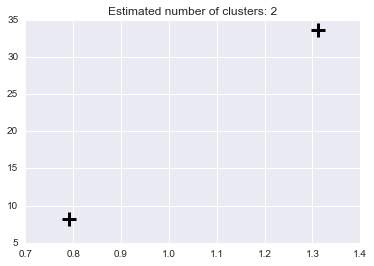

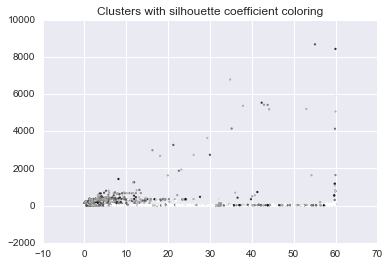

In [62]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np

n_clusters = 2
data = X
model = KMeans(init='k-means++', n_clusters=n_clusters, n_init=1).fit(data)
# model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(data)
#model = DBSCAN(eps=0.15, min_samples=10).fit(data)
s_size = len(data)/2
print("length of data = ", s_size)
labels_pred = model.labels_
labels_true = y
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print( len(set(labels)))
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels_pred))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels_pred))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels_pred))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels_pred))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(data, labels_pred, sample_size=s_size))

# Got memory error with silhouette/ reduced sample size in half
silhouette_per_sample = metrics.silhouette_samples(data,labels_pred)

# get the middle of each cluster
centroids = []
for lab in range(0,n_clusters_):

    centroids.append( [np.mean(data[np.where(labels_pred==lab),0]), np.mean(data[np.where(labels_pred==lab),1])] )
centroids = np.array(centroids)

plt.figure()
#plt.scatter(data[:, 0], data[:, 1], c=labels,           
#                    cmap=plt.cm.spectral, s=5, linewidths=0)

if len(centroids)>0:
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='+', s=200, linewidths=3, color='k', zorder=10)  # plot the centroids
plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.figure()
plt.scatter(data[:, 0], data[:, 1], c=silhouette_per_sample,
                cmap=plt.cm.gray, s=5, linewidths=0)
plt.title('Clusters with silhouette coefficient coloring')
plt.show()

In [64]:
#curious if we run do feature reduction with PCA and run cluster algorith on reduced features if 
# the metrics like homogeneity improve
pca = PCA(n_components=3)
x_pca = pca.fit(X)

# Percentage of variance explained for each components
print('explained variance ratio (first 3 components): %s' % (100 * pca.explained_variance_ratio_) )
print(sum(pca.explained_variance_ratio_))

explained variance ratio (first 3 components): [ 80.59365547  18.59309631   0.81310102]
0.999998528038


In [82]:
from time import time

# ref: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py
s_size = 42
sample_size = s_size
n_samples = s_size
n_digits = n_clusters  
n_features = len(dfcopy.columns)


print("n_digits(num categories): %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(79 * '_')
print('% 9s' % 'init'
      '    time  inertia    homo   compl  v-meas     ARI AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

   
bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=1),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=1),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')



n_digits(num categories): 2, 	 n_samples 42, 	 n_features 42
_______________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   0.43s    52908653520319819022336   1.000   1.000   1.000   1.000   1.000    0.602
   random   0.33s    52908655521244209217536   1.000   1.000   1.000   1.000   1.000    0.590
PCA-based   0.38s    52908653520319819022336   1.000   1.000   1.000   1.000   1.000    0.639
_______________________________________________________________________________


In [81]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=1)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the packets dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

MemoryError: 

#### Evaluate and Compare

In [ ]:
Ref:
(a)http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html
    score between 0.0 and 1.0. 1.0 stands for perfectly homogeneous labeling

#### Visualize Results

In [ ]:
"""
    Can we visualize a data set with this many features?
    Can we visualize on the attack categories?
"""

#### Summarize the Ramifications

## Deployment

Resuse from Lab 2

- *Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?*
- *How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?*
- *How would your deploy your model for interested parties?*
- *What other data should be collected?*
- *How often would the model need to be updated, etc.?*

## Exceptional Work